# Load and Extract Dataset

In [3]:
from google.colab import drive
import os
import zipfile
drive.mount('/content/gdrive')
# zip_ref = zipfile.ZipFile("/content/gdrive/My Drive/Copy of A_05_Part_02_Dataset.zip", 'r')
# zip_ref.extractall("/content/gdrive/My Drive/Data")
# zip_ref.close()
os.chdir("/content/gdrive/My Drive/Data/A_05_Part_02_Dataset")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Packages Import

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import csv

# Data Transformation

In [5]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

vali_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder('Train', transform=train_transforms)
vali_data = datasets.ImageFolder('Validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
valiloader = torch.utils.data.DataLoader(vali_data, batch_size=16, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


In [0]:
class ImageFolderWithPaths(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
data_dir = "Test"
testset = ImageFolderWithPaths(data_dir, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


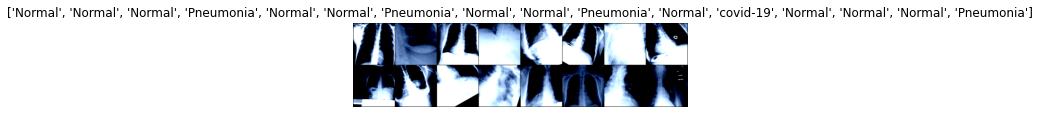

In [7]:
class_names = {0: 'covid-19', 1: 'Normal', 2:'Pneumonia'}
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    classes = classes.numpy()
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

# VGG-16 without Focal Loss

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

In [0]:
features = list(vgg16.classifier.children())[0:0] # Remove All FC Layers

In [0]:
features.extend([nn.Linear(25088, 4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096, 4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096, len(class_names))])

In [0]:
vgg16.classifier = nn.Sequential(*features)

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.00125, momentum=0.9)

In [0]:
from tqdm import tqdm
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.train()

train_loss = []
vali_loss = []
train_acc = []
vali_acc = []
batch_size = 16

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    correct = 0
    total = 0

    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        one_hot = torch.zeros(labels.size(0), 3)
        for batch_item in range(labels.size(0)):
            if labels[batch_item].cpu().numpy() == 0:
                one_hot[batch_item] = torch.tensor([1, 1, 0])
            if labels[batch_item].cpu().numpy() == 1:
                one_hot[batch_item] = torch.tensor([0, 1, 0])
            if labels[batch_item].cpu().numpy() == 2:
                one_hot[batch_item] = torch.tensor([0, 0, 1])
        inputs, labels, one_hot = inputs.to(device), labels.to(device), one_hot.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call
        # forward + backward + optimize
        outputs = vgg16(inputs)          
        one_hot = one_hot.float()     #----> forward pass
        loss = criterion(outputs, one_hot)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        outputs = torch.sigmoid(outputs)
        pred = torch.as_tensor((outputs - 0.5) > 0, dtype=torch.int32)
        total += labels.size(0)
        for batch_item in range(labels.size(0)):
            if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
                correct += 1
        # print statistics
        running_loss += loss.item()
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, i * len(inputs), len(trainloader.dataset),100. * i / len(trainloader), loss))


    train_loss.append(running_loss)
    train_acc.append(100 * correct / total)
    print(f'Training Loss: {running_loss} Training Accuracy {(100 * correct / total)}')
    vali_runing = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(valiloader, 0):
         # get the inputs
        inputs, labels = data
        one_hot = torch.zeros(labels.size(0), 3)
        for batch_item in range(labels.size(0)):
            if labels[batch_item].cpu().numpy() == 0:
                one_hot[batch_item] = torch.tensor([1, 1, 0])
            if labels[batch_item].cpu().numpy() == 1:
                one_hot[batch_item] = torch.tensor([0, 1, 0])
            if labels[batch_item].cpu().numpy() == 2:
                one_hot[batch_item] = torch.tensor([0, 0, 1])

        inputs, labels, one_hot = Variable(inputs.to(device)), Variable(labels.to(device)), Variable(one_hot.to(device))

        output = vgg16(inputs)
        one_hot = one_hot.float()
        loss = criterion(output, one_hot)
        vali_runing += loss.item()
        output = torch.sigmoid(output)
        pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
        total += labels.size(0)
        for batch_item in range(labels.size(0)):
            if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
                correct += 1

    vali_loss.append(vali_runing)
    vali_acc.append(100 * correct / total)
    print(f'Validation Loss: {vali_runing} Validation Accuracy {(100 * correct / total)}')
    torch.save(vgg16.state_dict(), '/content/vgg16_without_FL.pth')

print('Finished Training')

Train Epoch: 0 [3096/6200 (100%)]	Loss: 0.184023: : 388it [05:38,  1.15it/s]


Training Loss: 127.44453482329845 Training Accuracy 77.25806451612904
Validation Loss: 7.706734739243984 Validation Accuracy 89.01273885350318


Train Epoch: 1 [3096/6200 (100%)]	Loss: 0.214561: : 388it [05:37,  1.15it/s]


Training Loss: 96.40992226265371 Training Accuracy 84.58064516129032
Validation Loss: 7.114433114416897 Validation Accuracy 88.53503184713375


Train Epoch: 2 [3096/6200 (100%)]	Loss: 0.228209: : 388it [05:38,  1.15it/s]


Training Loss: 90.32562723755836 Training Accuracy 86.09677419354838
Validation Loss: 6.9573295682203025 Validation Accuracy 89.01273885350318


Train Epoch: 3 [3096/6200 (100%)]	Loss: 0.125278: : 388it [05:38,  1.15it/s]


Training Loss: 84.99537259340286 Training Accuracy 86.7258064516129
Validation Loss: 6.240389309823513 Validation Accuracy 91.0828025477707


Train Epoch: 4 [3096/6200 (100%)]	Loss: 0.069491: : 388it [05:40,  1.14it/s]


Training Loss: 81.05034072324634 Training Accuracy 86.75806451612904
Validation Loss: 6.294350443407893 Validation Accuracy 90.44585987261146


Train Epoch: 5 [3096/6200 (100%)]	Loss: 0.061050: : 388it [05:41,  1.14it/s]


Training Loss: 77.87703628838062 Training Accuracy 87.91935483870968
Validation Loss: 5.990029841661453 Validation Accuracy 90.92356687898089


Train Epoch: 6 [3096/6200 (100%)]	Loss: 0.260920: : 388it [05:45,  1.12it/s]


Training Loss: 78.16140501014888 Training Accuracy 88.03225806451613
Validation Loss: 5.708158530294895 Validation Accuracy 91.56050955414013


Train Epoch: 7 [3096/6200 (100%)]	Loss: 0.533562: : 388it [05:44,  1.13it/s]


Training Loss: 75.02107376791537 Training Accuracy 88.56451612903226
Validation Loss: 5.870566073805094 Validation Accuracy 90.76433121019109


Train Epoch: 8 [1904/6200 (31%)]	Loss: 0.059789: : 120it [01:46,  1.14it/s]

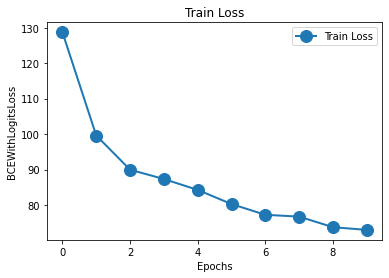

In [13]:
fig, ax = plt.subplots()
ax.plot(train_loss, marker='o', linestyle='-', linewidth=2, markersize=12, label='Train Loss')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('BCEWithLogitsLoss')
ax.set_title('Train Loss')
plt.show()

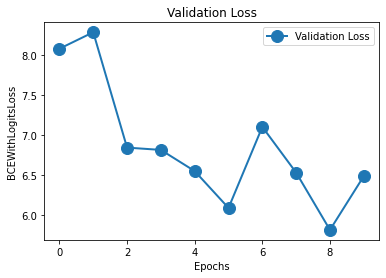

In [15]:
fig, ax = plt.subplots()
ax.plot(vali_loss, marker='o', linestyle='-', linewidth=2, markersize=12, label='Validation Loss')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('BCEWithLogitsLoss')
ax.set_title('Validation Loss')
plt.show()

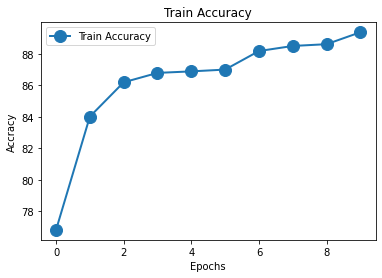

In [17]:
fig, ax = plt.subplots()
ax.plot(train_acc, marker='o', linestyle='-', linewidth=2, markersize=12, label='Train Accuracy')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accracy')
ax.set_title('Train Accuracy')
plt.show()

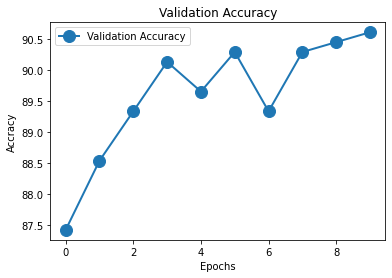

In [19]:
fig, ax = plt.subplots()
ax.plot(vali_acc, marker='o', linestyle='-', linewidth=2, markersize=12, label='Validation Accuracy')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accracy')
ax.set_title('Validation Accuracy')
plt.show()

In [31]:
pred_vali = []
labels_vali = []
correct = 0
total = 0
with torch.no_grad():
  for i, data in enumerate(valiloader, 0):
    # get the inputs
    inputs, labels = data
    one_hot = torch.zeros(labels.size(0), 3)
    for batch_item in range(labels.size(0)):
        if labels[batch_item].cpu().numpy() == 0:
            one_hot[batch_item] = torch.tensor([1, 1, 0])
        if labels[batch_item].cpu().numpy() == 1:
            one_hot[batch_item] = torch.tensor([0, 1, 0])
        if labels[batch_item].cpu().numpy() == 2:
            one_hot[batch_item] = torch.tensor([0, 0, 1])

    inputs, labels, one_hot = Variable(inputs.to(device)), Variable(labels.to(device)), Variable(one_hot.to(device))

    output = vgg16(inputs)
    one_hot = one_hot.float()
    output = torch.sigmoid(output)
    pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)

    pred_vali += list(pred.cpu().numpy())
    labels_vali += list(one_hot.cpu().numpy())
    total += labels.size(0)
    for batch_item in range(labels.size(0)):
        if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
            correct += 1

conf_matrix = multilabel_confusion_matrix(pred_vali, labels_vali)
print(conf_matrix)
print('\n')
print(f'Validation Accuracy {(100 * correct / total)}')

[[[600  28]
  [  0   0]]

 [[174  12]
  [ 26 416]]

 [[415  26]
  [ 13 174]]]


Validation Accuracy 90.28662420382166


In [32]:
pred_train = []
labels_train = []
correct = 0
total = 0
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    one_hot = torch.zeros(labels.size(0), 3)
    for batch_item in range(labels.size(0)):
        if labels[batch_item].cpu().numpy() == 0:
            one_hot[batch_item] = torch.tensor([1, 1, 0])
        if labels[batch_item].cpu().numpy() == 1:
            one_hot[batch_item] = torch.tensor([0, 1, 0])
        if labels[batch_item].cpu().numpy() == 2:
            one_hot[batch_item] = torch.tensor([0, 0, 1])

    inputs, labels, one_hot = Variable(inputs.to(device)), Variable(labels.to(device)), Variable(one_hot.to(device))

    output = vgg16(inputs)
    one_hot = one_hot.float()
    output = torch.sigmoid(output)
    pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)

    pred_train += list(pred.cpu().numpy())
    labels_train += list(one_hot.cpu().numpy())
    total += labels.size(0)
    for batch_item in range(labels.size(0)):
        if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
            correct += 1

conf_matrix = multilabel_confusion_matrix(pred_train, labels_train)
print(conf_matrix)
print('\n')
print(f'Training Accuracy {(100 * correct / total)}')

[[[6000  190]
  [   0   10]]

 [[1655  206]
  [ 345 3994]]

 [[3995  350]
  [ 205 1650]]]


Training Accuracy 88.95161290322581


In [0]:
# Test CSV File
f = open('vgg16_without_FL.csv', 'w')
writer = csv.writer(f)
for inputs, label, path in testloader:
    # use the above variables freely
    inputs = Variable(inputs.to(device))
    output = vgg16(inputs)
    output = torch.sigmoid(output)
    pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
    input_row = []
    input_row.append(str(list(path)[0]).split('/')[-1])
    input_row.append(int(pred[0][0].cpu().numpy()))
    input_row.append(int(pred[0][1].cpu().numpy()))
    input_row.append(int(pred[0][2].cpu().numpy()))
    writer.writerow(input_row)
f.close()

# Resnet-18 without Focal Loss

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
features = list(resnet18.fc.children())[0:0]

features.extend([nn.Linear(512, 390)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(390, len(class_names))])

resnet18.fc = nn.Sequential(*features)

In [0]:
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.00125, momentum=0.9)

In [32]:
from tqdm import tqdm
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
resnet18.train()

train_loss = []
vali_loss = []
train_acc = []
vali_acc = []
batch_size = 16

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    correct = 0
    total = 0

    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        one_hot = torch.zeros(labels.size(0), 3)
        for batch_item in range(labels.size(0)):
            if labels[batch_item].cpu().numpy() == 0:
                one_hot[batch_item] = torch.tensor([1, 1, 0])
            if labels[batch_item].cpu().numpy() == 1:
                one_hot[batch_item] = torch.tensor([0, 1, 0])
            if labels[batch_item].cpu().numpy() == 2:
                one_hot[batch_item] = torch.tensor([0, 0, 1])
        inputs, labels, one_hot = inputs.to(device), labels.to(device), one_hot.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call
        # forward + backward + optimize
        outputs =resnet18(inputs)          
        one_hot = one_hot.float()     #----> forward pass
        loss = criterion(outputs, one_hot)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        outputs = torch.sigmoid(outputs)
        pred = torch.as_tensor((outputs - 0.5) > 0, dtype=torch.int32)
        total += labels.size(0)
        for batch_item in range(labels.size(0)):
            if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
                correct += 1
        # print statistics
        running_loss += loss.item()
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, i * len(inputs), len(trainloader.dataset),100. * i / len(trainloader), loss))


    train_loss.append(running_loss)
    train_acc.append(100 * correct / total)
    print(f'Training Loss: {running_loss} Training Accuracy {(100 * correct / total)}')
    vali_runing = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(valiloader, 0):
         # get the inputs
        inputs, labels = data
        one_hot = torch.zeros(labels.size(0), 3)
        for batch_item in range(labels.size(0)):
            if labels[batch_item].cpu().numpy() == 0:
                one_hot[batch_item] = torch.tensor([1, 1, 0])
            if labels[batch_item].cpu().numpy() == 1:
                one_hot[batch_item] = torch.tensor([0, 1, 0])
            if labels[batch_item].cpu().numpy() == 2:
                one_hot[batch_item] = torch.tensor([0, 0, 1])

        inputs, labels, one_hot = Variable(inputs.to(device)), Variable(labels.to(device)), Variable(one_hot.to(device))

        output = resnet18(inputs)
        one_hot = one_hot.float()
        loss = criterion(output, one_hot)
        vali_runing += loss.item()
        output = torch.sigmoid(output)
        pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
        total += labels.size(0)
        for batch_item in range(labels.size(0)):
            if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
                correct += 1

    vali_loss.append(vali_runing)
    vali_acc.append(100 * correct / total)
    print(f'Validation Loss: {vali_runing} Validation Accuracy {(100 * correct / total)}')
    torch.save(resnet18.state_dict(), '/content/resnet18_without_FL.pth')

print('Finished Training')

Train Epoch: 0 [3096/6200 (100%)]	Loss: 0.218341: : 388it [03:10,  2.04it/s]


Training Loss: 132.4797499626875 Training Accuracy 74.79032258064517


0it [00:00, ?it/s]

Validation Loss: 9.42025151848793 Validation Accuracy 85.19108280254777


Train Epoch: 1 [3096/6200 (100%)]	Loss: 0.174389: : 388it [03:10,  2.03it/s]


Training Loss: 99.23326060175896 Training Accuracy 83.54838709677419


0it [00:00, ?it/s]

Validation Loss: 7.67754078656435 Validation Accuracy 88.21656050955414


Train Epoch: 2 [3096/6200 (100%)]	Loss: 0.564326: : 388it [03:10,  2.04it/s]


Training Loss: 89.32463634759188 Training Accuracy 85.64516129032258


0it [00:00, ?it/s]

Validation Loss: 7.211324743926525 Validation Accuracy 88.05732484076434


Train Epoch: 3 [3096/6200 (100%)]	Loss: 0.109745: : 388it [03:09,  2.05it/s]


Training Loss: 86.78020755574107 Training Accuracy 86.33870967741936


0it [00:00, ?it/s]

Validation Loss: 6.622630499303341 Validation Accuracy 88.21656050955414


Train Epoch: 4 [3096/6200 (100%)]	Loss: 0.378634: : 388it [03:11,  2.03it/s]


Training Loss: 85.49106142297387 Training Accuracy 86.40322580645162


0it [00:00, ?it/s]

Validation Loss: 7.6820070669054985 Validation Accuracy 87.10191082802548


Train Epoch: 5 [3096/6200 (100%)]	Loss: 0.096872: : 388it [03:13,  2.01it/s]


Training Loss: 79.62084951996803 Training Accuracy 87.37096774193549


0it [00:00, ?it/s]

Validation Loss: 6.663598727434874 Validation Accuracy 88.37579617834395


Train Epoch: 6 [3096/6200 (100%)]	Loss: 0.047990: : 388it [03:11,  2.02it/s]


Training Loss: 79.09686318039894 Training Accuracy 87.56451612903226


0it [00:00, ?it/s]

Validation Loss: 5.9924074076116085 Validation Accuracy 89.96815286624204


Train Epoch: 7 [3096/6200 (100%)]	Loss: 0.049874: : 388it [03:11,  2.03it/s]


Training Loss: 78.15859004482627 Training Accuracy 87.56451612903226


0it [00:00, ?it/s]

Validation Loss: 5.510450981557369 Validation Accuracy 91.56050955414013


Train Epoch: 8 [3096/6200 (100%)]	Loss: 0.044299: : 388it [03:07,  2.07it/s]


Training Loss: 75.3118397295475 Training Accuracy 88.7258064516129


0it [00:00, ?it/s]

Validation Loss: 5.384225640445948 Validation Accuracy 92.03821656050955


Train Epoch: 9 [3096/6200 (100%)]	Loss: 0.040466: : 388it [03:08,  2.06it/s]


Training Loss: 72.8388738296926 Training Accuracy 89.20967741935483
Validation Loss: 5.376074619591236 Validation Accuracy 91.87898089171975
Finished Training


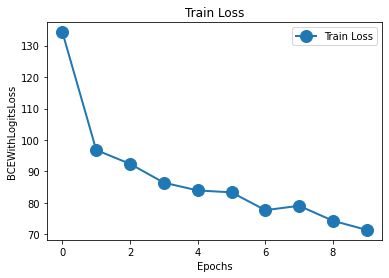

In [80]:
fig, ax = plt.subplots()
ax.plot(train_loss, marker='o', linestyle='-', linewidth=2, markersize=12, label='Train Loss')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('BCEWithLogitsLoss')
ax.set_title('Train Loss')
plt.show()

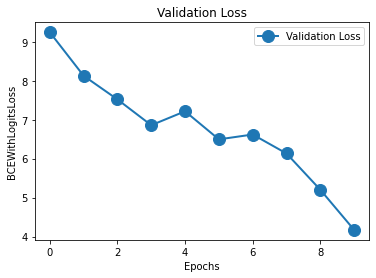

In [81]:
fig, ax = plt.subplots()
ax.plot(vali_loss, marker='o', linestyle='-', linewidth=2, markersize=12, label='Validation Loss')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('BCEWithLogitsLoss')
ax.set_title('Validation Loss')
plt.show()

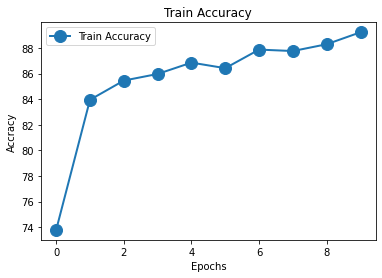

In [82]:
fig, ax = plt.subplots()
ax.plot(train_acc, marker='o', linestyle='-', linewidth=2, markersize=12, label='Train Accuracy')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accracy')
ax.set_title('Train Accuracy')
plt.show()

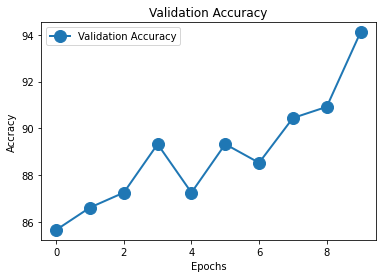

In [83]:
fig, ax = plt.subplots()
ax.plot(vali_acc, marker='o', linestyle='-', linewidth=2, markersize=12, label='Validation Accuracy')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accracy')
ax.set_title('Validation Accuracy')
plt.show()

In [84]:
pred_vali = []
labels_vali = []
correct = 0
total = 0
with torch.no_grad():
  for i, data in enumerate(valiloader, 0):
    # get the inputs
    inputs, labels = data
    one_hot = torch.zeros(labels.size(0), 3)
    for batch_item in range(labels.size(0)):
        if labels[batch_item].cpu().numpy() == 0:
            one_hot[batch_item] = torch.tensor([1, 1, 0])
        if labels[batch_item].cpu().numpy() == 1:
            one_hot[batch_item] = torch.tensor([0, 1, 0])
        if labels[batch_item].cpu().numpy() == 2:
            one_hot[batch_item] = torch.tensor([0, 0, 1])

    inputs, labels, one_hot = Variable(inputs.to(device)), Variable(labels.to(device)), Variable(one_hot.to(device))

    output = resnet18(inputs)
    one_hot = one_hot.float()
    output = torch.sigmoid(output)
    pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)

    pred_vali += list(pred.cpu().numpy())
    labels_vali += list(one_hot.cpu().numpy())
    total += labels.size(0)
    for batch_item in range(labels.size(0)):
        if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
            correct += 1

conf_matrix = multilabel_confusion_matrix(pred_vali, labels_vali)
print(conf_matrix)
print('\n')
print(f'Validation Accuracy {(100 * correct / total)}')

[[[599  16]
  [  1  12]]

 [[180  14]
  [ 20 414]]

 [[415  21]
  [ 13 179]]]


Validation Accuracy 91.87898089171975


In [85]:
pred_train = []
labels_train = []
correct = 0
total = 0
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    one_hot = torch.zeros(labels.size(0), 3)
    for batch_item in range(labels.size(0)):
        if labels[batch_item].cpu().numpy() == 0:
            one_hot[batch_item] = torch.tensor([1, 1, 0])
        if labels[batch_item].cpu().numpy() == 1:
            one_hot[batch_item] = torch.tensor([0, 1, 0])
        if labels[batch_item].cpu().numpy() == 2:
            one_hot[batch_item] = torch.tensor([0, 0, 1])

    inputs, labels, one_hot = Variable(inputs.to(device)), Variable(labels.to(device)), Variable(one_hot.to(device))

    output = resnet18(inputs)
    one_hot = one_hot.float()
    output = torch.sigmoid(output)
    pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)

    pred_train += list(pred.cpu().numpy())
    labels_train += list(one_hot.cpu().numpy())
    total += labels.size(0)
    for batch_item in range(labels.size(0)):
        if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
            correct += 1

conf_matrix = multilabel_confusion_matrix(pred_train, labels_train)
print(conf_matrix)
print('\n')
print(f'Training Accuracy {(100 * correct / total)}')

[[[5988  126]
  [  12   74]]

 [[1673  247]
  [ 327 3953]]

 [[3953  325]
  [ 247 1675]]]


Training Accuracy 89.2741935483871


In [0]:
# Test CSV File
f = open('resnet18_without_FL.csv', 'w')
writer = csv.writer(f)
for inputs, label, path in testloader:
    # use the above variables freely
    inputs = Variable(inputs.to(device))
    output = vgg16(inputs)
    output = torch.sigmoid(output)
    pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
    input_row = []
    input_row.append(str(list(path)[0]).split('/')[-1])
    input_row.append(int(pred[0][0].cpu().numpy()))
    input_row.append(int(pred[0][1].cpu().numpy()))
    input_row.append(int(pred[0][2].cpu().numpy()))
    writer.writerow(input_row)
f.close()

# VGG-16 With Focal Loss

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
features = list(vgg16.classifier.children())[0:0] # Remove All FC Layers
features.extend([nn.Linear(25088, 4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096, 4096)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(4096, len(class_names))])
vgg16.classifier = nn.Sequential(*features)

class ModelFocalLoss(nn.Module):
    # Import Class
    # Set Parameters
    def __init__(self, alpha=1, gamma=1.8, logits=True, reduce=True):
        super(ModelFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            bce_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            bce_loss = torch.nn.functional.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-bce_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [0]:
Epochs = 10
criterion = ModelFocalLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.00125, momentum=0.9)

In [11]:
from tqdm import tqdm
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)
vgg16.train()

train_loss = []
vali_loss = []
train_acc = []
vali_acc = []
batch_size = 16

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    correct = 0
    total = 0

    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        one_hot = torch.zeros(labels.size(0), 3)
        for batch_item in range(labels.size(0)):
            if labels[batch_item].cpu().numpy() == 0:
                one_hot[batch_item] = torch.tensor([1, 1, 0])
            if labels[batch_item].cpu().numpy() == 1:
                one_hot[batch_item] = torch.tensor([0, 1, 0])
            if labels[batch_item].cpu().numpy() == 2:
                one_hot[batch_item] = torch.tensor([0, 0, 1])
        inputs, labels, one_hot = inputs.to(device), labels.to(device), one_hot.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call
        # forward + backward + optimize
        outputs = vgg16(inputs)          
        one_hot = one_hot.float()     #----> forward pass
        loss = criterion(outputs, one_hot)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        outputs = torch.sigmoid(outputs)
        pred = torch.as_tensor((outputs - 0.5) > 0, dtype=torch.int32)
        total += labels.size(0)
        for batch_item in range(labels.size(0)):
            if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
                correct += 1
        # print statistics
        running_loss += loss.item()
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, i * len(inputs), len(trainloader.dataset),100. * i / len(trainloader), loss))


    train_loss.append(running_loss)
    train_acc.append(100 * correct / total)
    print(f'Training Loss: {running_loss} Training Accuracy {(100 * correct / total)}')
    vali_runing = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(valiloader, 0):
         # get the inputs
        inputs, labels = data
        one_hot = torch.zeros(labels.size(0), 3)
        for batch_item in range(labels.size(0)):
            if labels[batch_item].cpu().numpy() == 0:
                one_hot[batch_item] = torch.tensor([1, 1, 0])
            if labels[batch_item].cpu().numpy() == 1:
                one_hot[batch_item] = torch.tensor([0, 1, 0])
            if labels[batch_item].cpu().numpy() == 2:
                one_hot[batch_item] = torch.tensor([0, 0, 1])

        inputs, labels, one_hot = Variable(inputs.to(device)), Variable(labels.to(device)), Variable(one_hot.to(device))

        output = vgg16(inputs)
        one_hot = one_hot.float()
        loss = criterion(output, one_hot)
        vali_runing += loss.item()
        output = torch.sigmoid(output)
        pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
        total += labels.size(0)
        for batch_item in range(labels.size(0)):
            if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
                correct += 1

    vali_loss.append(vali_runing)
    vali_acc.append(100 * correct / total)
    print(f'Validation Loss: {vali_runing} Validation Accuracy {(100 * correct / total)}')
    torch.save(vgg16.state_dict(), '/content/vgg16_focal_loss.pth')

print('Finished Training')

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [3096/6200 (100%)]	Loss: 0.094608: : 388it [53:57,  8.34s/it]


Training Loss: 40.2714416757226 Training Accuracy 74.20967741935483
Validation Loss: 3.017808811739087 Validation Accuracy 84.87261146496816


Train Epoch: 1 [3096/6200 (100%)]	Loss: 0.047232: : 388it [05:40,  1.14it/s]


Training Loss: 31.25225073285401 Training Accuracy 83.1774193548387
Validation Loss: 2.481051703915 Validation Accuracy 87.89808917197452


Train Epoch: 2 [3096/6200 (100%)]	Loss: 0.022643: : 388it [05:34,  1.16it/s]


Training Loss: 28.597688917070627 Training Accuracy 84.62903225806451
Validation Loss: 2.1566150691360235 Validation Accuracy 89.80891719745223


Train Epoch: 3 [3096/6200 (100%)]	Loss: 0.233441: : 388it [05:40,  1.14it/s]


Training Loss: 26.394085781648755 Training Accuracy 86.14516129032258
Validation Loss: 2.1143625173717737 Validation Accuracy 89.49044585987261


Train Epoch: 4 [3096/6200 (100%)]	Loss: 0.008909: : 388it [05:41,  1.14it/s]


Training Loss: 26.25389400217682 Training Accuracy 86.29032258064517
Validation Loss: 2.087428830564022 Validation Accuracy 89.96815286624204


Train Epoch: 5 [3096/6200 (100%)]	Loss: 0.006940: : 388it [05:41,  1.13it/s]


Training Loss: 24.980207341723144 Training Accuracy 86.2741935483871
Validation Loss: 2.405607015825808 Validation Accuracy 88.05732484076434


Train Epoch: 6 [3096/6200 (100%)]	Loss: 0.052899: : 388it [05:39,  1.14it/s]


Training Loss: 24.307394661940634 Training Accuracy 87.40322580645162
Validation Loss: 2.038444451056421 Validation Accuracy 90.44585987261146


Train Epoch: 7 [3096/6200 (100%)]	Loss: 0.112925: : 388it [05:37,  1.15it/s]


Training Loss: 23.840892989188433 Training Accuracy 87.58064516129032
Validation Loss: 1.9302603090181947 Validation Accuracy 90.12738853503184


Train Epoch: 8 [3096/6200 (100%)]	Loss: 0.014986: : 388it [05:39,  1.14it/s]


Training Loss: 22.91388596780598 Training Accuracy 87.79032258064517
Validation Loss: 1.6352396397851408 Validation Accuracy 90.76433121019109


Train Epoch: 9 [3096/6200 (100%)]	Loss: 0.029844: : 388it [05:38,  1.14it/s]


Training Loss: 23.25886405352503 Training Accuracy 87.38709677419355
Validation Loss: 2.0401136078871787 Validation Accuracy 91.24203821656052
Finished Training


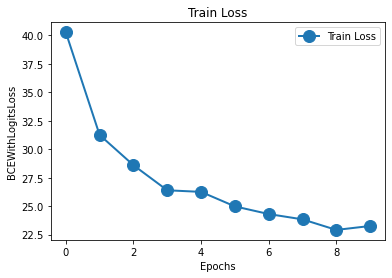

In [12]:
fig, ax = plt.subplots()
ax.plot(train_loss, marker='o', linestyle='-', linewidth=2, markersize=12, label='Train Loss')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('BCEWithLogitsLoss')
ax.set_title('Train Loss')
plt.show()

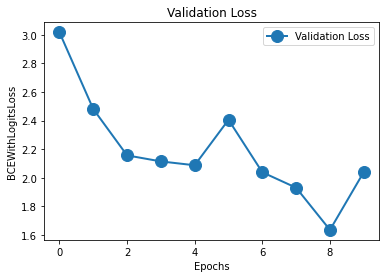

In [13]:
fig, ax = plt.subplots()
ax.plot(vali_loss, marker='o', linestyle='-', linewidth=2, markersize=12, label='Validation Loss')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('BCEWithLogitsLoss')
ax.set_title('Validation Loss')
plt.show()

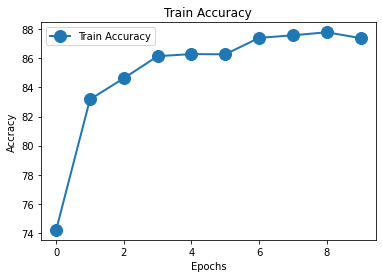

In [14]:
fig, ax = plt.subplots()
ax.plot(train_acc, marker='o', linestyle='-', linewidth=2, markersize=12, label='Train Accuracy')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accracy')
ax.set_title('Train Accuracy')
plt.show()

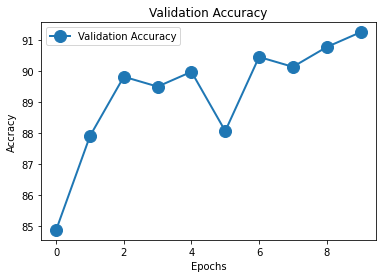

In [15]:
fig, ax = plt.subplots()
ax.plot(vali_acc, marker='o', linestyle='-', linewidth=2, markersize=12, label='Validation Accuracy')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accracy')
ax.set_title('Validation Accuracy')
plt.show()

In [16]:
pred_vali = []
labels_vali = []
correct = 0
total = 0
with torch.no_grad():
  for i, data in enumerate(valiloader, 0):
    # get the inputs
    inputs, labels = data
    one_hot = torch.zeros(labels.size(0), 3)
    for batch_item in range(labels.size(0)):
        if labels[batch_item].cpu().numpy() == 0:
            one_hot[batch_item] = torch.tensor([1, 1, 0])
        if labels[batch_item].cpu().numpy() == 1:
            one_hot[batch_item] = torch.tensor([0, 1, 0])
        if labels[batch_item].cpu().numpy() == 2:
            one_hot[batch_item] = torch.tensor([0, 0, 1])

    inputs, labels, one_hot = Variable(inputs.to(device)), Variable(labels.to(device)), Variable(one_hot.to(device))

    output = vgg16(inputs)
    one_hot = one_hot.float()
    output = torch.sigmoid(output)
    pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)

    pred_vali += list(pred.cpu().numpy())
    labels_vali += list(one_hot.cpu().numpy())
    total += labels.size(0)
    for batch_item in range(labels.size(0)):
        if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
            correct += 1

conf_matrix = multilabel_confusion_matrix(pred_vali, labels_vali)
print(conf_matrix)
print('\n')
print(f'Validation Accuracy {(100 * correct / total)}')

[[[600  28]
  [  0   0]]

 [[185  18]
  [ 15 410]]

 [[410  18]
  [ 18 182]]]


Validation Accuracy 90.60509554140127


In [17]:
pred_train = []
labels_train = []
correct = 0
total = 0
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    one_hot = torch.zeros(labels.size(0), 3)
    for batch_item in range(labels.size(0)):
        if labels[batch_item].cpu().numpy() == 0:
            one_hot[batch_item] = torch.tensor([1, 1, 0])
        if labels[batch_item].cpu().numpy() == 1:
            one_hot[batch_item] = torch.tensor([0, 1, 0])
        if labels[batch_item].cpu().numpy() == 2:
            one_hot[batch_item] = torch.tensor([0, 0, 1])

    inputs, labels, one_hot = Variable(inputs.to(device)), Variable(labels.to(device)), Variable(one_hot.to(device))

    output = vgg16(inputs)
    one_hot = one_hot.float()
    output = torch.sigmoid(output)
    pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)

    pred_train += list(pred.cpu().numpy())
    labels_train += list(one_hot.cpu().numpy())
    total += labels.size(0)
    for batch_item in range(labels.size(0)):
        if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
            correct += 1

conf_matrix = multilabel_confusion_matrix(pred_train, labels_train)
print(conf_matrix)
print('\n')
print(f'Training Accuracy {(100 * correct / total)}')

[[[5998  173]
  [   2   27]]

 [[1761  385]
  [ 239 3815]]

 [[3823  231]
  [ 377 1769]]]


Training Accuracy 88.08064516129032


In [0]:
# Test CSV File
f = open('vgg16_focal_loss.csv', 'w')
writer = csv.writer(f)
for inputs, label, path in testloader:
    # use the above variables freely
    inputs = Variable(inputs.to(device))
    output = vgg16(inputs)
    output = torch.sigmoid(output)
    pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
    input_row = []
    input_row.append(str(list(path)[0]).split('/')[-1])
    input_row.append(int(pred[0][0].cpu().numpy()))
    input_row.append(int(pred[0][1].cpu().numpy()))
    input_row.append(int(pred[0][2].cpu().numpy()))
    writer.writerow(input_row)
f.close()

# Resnet18 with Focal Loss

In [0]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
features = list(resnet18.fc.children())[0:0]

features.extend([nn.Linear(512, 390)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(390, len(class_names))])

resnet18.fc = nn.Sequential(*features)

class ModelFocalLoss(nn.Module):
    # Import Class
    # Set Parameters
    def __init__(self, alpha=1, gamma=1.8, logits=True, reduce=True):
        super(ModelFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            bce_loss = torch.nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            bce_loss = torch.nn.functional.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-bce_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [0]:
Epochs = 10
criterion = ModelFocalLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.00125, momentum=0.9)

In [22]:
from tqdm import tqdm
#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)
resnet18.train()

train_loss = []
vali_loss = []
train_acc = []
vali_acc = []
batch_size = 16

for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    correct = 0
    total = 0

    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        one_hot = torch.zeros(labels.size(0), 3)
        for batch_item in range(labels.size(0)):
            if labels[batch_item].cpu().numpy() == 0:
                one_hot[batch_item] = torch.tensor([1, 1, 0])
            if labels[batch_item].cpu().numpy() == 1:
                one_hot[batch_item] = torch.tensor([0, 1, 0])
            if labels[batch_item].cpu().numpy() == 2:
                one_hot[batch_item] = torch.tensor([0, 0, 1])
        inputs, labels, one_hot = inputs.to(device), labels.to(device), one_hot.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call
        # forward + backward + optimize
        outputs =resnet18(inputs)          
        one_hot = one_hot.float()     #----> forward pass
        loss = criterion(outputs, one_hot)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update
        outputs = torch.sigmoid(outputs)
        pred = torch.as_tensor((outputs - 0.5) > 0, dtype=torch.int32)
        total += labels.size(0)
        for batch_item in range(labels.size(0)):
            if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
                correct += 1
        # print statistics
        running_loss += loss.item()
        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, i * len(inputs), len(trainloader.dataset),100. * i / len(trainloader), loss))


    train_loss.append(running_loss)
    train_acc.append(100 * correct / total)
    print(f'Training Loss: {running_loss} Training Accuracy {(100 * correct / total)}')
    vali_runing = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(valiloader, 0):
         # get the inputs
        inputs, labels = data
        one_hot = torch.zeros(labels.size(0), 3)
        for batch_item in range(labels.size(0)):
            if labels[batch_item].cpu().numpy() == 0:
                one_hot[batch_item] = torch.tensor([1, 1, 0])
            if labels[batch_item].cpu().numpy() == 1:
                one_hot[batch_item] = torch.tensor([0, 1, 0])
            if labels[batch_item].cpu().numpy() == 2:
                one_hot[batch_item] = torch.tensor([0, 0, 1])

        inputs, labels, one_hot = Variable(inputs.to(device)), Variable(labels.to(device)), Variable(one_hot.to(device))

        output = resnet18(inputs)
        one_hot = one_hot.float()
        loss = criterion(output, one_hot)
        vali_runing += loss.item()
        output = torch.sigmoid(output)
        pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
        total += labels.size(0)
        for batch_item in range(labels.size(0)):
            if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
                correct += 1

    vali_loss.append(vali_runing)
    vali_acc.append(100 * correct / total)
    print(f'Validation Loss: {vali_runing} Validation Accuracy {(100 * correct / total)}')
    torch.save(resnet18.state_dict(), '/content/resnet18_focal_loss.pth')

print('Finished Training')

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
Train Epoch: 0 [3096/6200 (100%)]	Loss: 0.056167: : 388it [03:09,  2.04it/s]


Training Loss: 42.511721804738045 Training Accuracy 69.33870967741936


0it [00:00, ?it/s]

Validation Loss: 3.2404354326426983 Validation Accuracy 81.36942675159236


Train Epoch: 1 [3096/6200 (100%)]	Loss: 0.051675: : 388it [03:08,  2.06it/s]


Training Loss: 33.80578626319766 Training Accuracy 79.80645161290323


0it [00:00, ?it/s]

Validation Loss: 2.793141782283783 Validation Accuracy 84.55414012738854


Train Epoch: 2 [3096/6200 (100%)]	Loss: 0.035070: : 388it [03:08,  2.06it/s]


Training Loss: 30.34750384092331 Training Accuracy 82.58064516129032


0it [00:00, ?it/s]

Validation Loss: 2.4917661491781473 Validation Accuracy 86.94267515923566


Train Epoch: 3 [3096/6200 (100%)]	Loss: 0.039665: : 388it [03:18,  1.95it/s]


Training Loss: 29.256578957661986 Training Accuracy 84.41935483870968


0it [00:00, ?it/s]

Validation Loss: 2.4580050725489855 Validation Accuracy 86.14649681528662


Train Epoch: 4 [3096/6200 (100%)]	Loss: 0.081366: : 388it [03:14,  2.00it/s]


Training Loss: 28.302089877426624 Training Accuracy 83.96774193548387


0it [00:00, ?it/s]

Validation Loss: 2.4091337621212006 Validation Accuracy 87.10191082802548


Train Epoch: 5 [3096/6200 (100%)]	Loss: 0.087930: : 388it [03:13,  2.00it/s]


Training Loss: 27.13574375398457 Training Accuracy 85.1774193548387


0it [00:00, ?it/s]

Validation Loss: 2.3659000350162387 Validation Accuracy 87.89808917197452


Train Epoch: 6 [3096/6200 (100%)]	Loss: 0.060502: : 388it [03:15,  1.98it/s]


Training Loss: 26.496406325139105 Training Accuracy 85.56451612903226


0it [00:00, ?it/s]

Validation Loss: 2.2931534089148045 Validation Accuracy 88.53503184713375


Train Epoch: 7 [3096/6200 (100%)]	Loss: 0.065666: : 388it [03:15,  1.98it/s]


Training Loss: 25.999859218485653 Training Accuracy 85.46774193548387


0it [00:00, ?it/s]

Validation Loss: 2.1543134469538927 Validation Accuracy 88.53503184713375


Train Epoch: 8 [3096/6200 (100%)]	Loss: 0.121795: : 388it [03:20,  1.93it/s]


Training Loss: 25.964367730543017 Training Accuracy 86.06451612903226


0it [00:00, ?it/s]

Validation Loss: 2.039679132401943 Validation Accuracy 89.3312101910828


Train Epoch: 9 [3096/6200 (100%)]	Loss: 0.012869: : 388it [03:18,  1.95it/s]


Training Loss: 24.87841859087348 Training Accuracy 86.61290322580645
Validation Loss: 1.983172968029976 Validation Accuracy 90.44585987261146
Finished Training


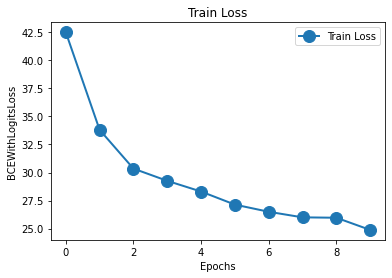

In [23]:
fig, ax = plt.subplots()
ax.plot(train_loss, marker='o', linestyle='-', linewidth=2, markersize=12, label='Train Loss')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('BCEWithLogitsLoss')
ax.set_title('Train Loss')
plt.show()

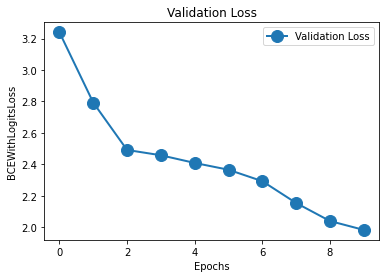

In [24]:
fig, ax = plt.subplots()
ax.plot(vali_loss, marker='o', linestyle='-', linewidth=2, markersize=12, label='Validation Loss')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('BCEWithLogitsLoss')
ax.set_title('Validation Loss')
plt.show()

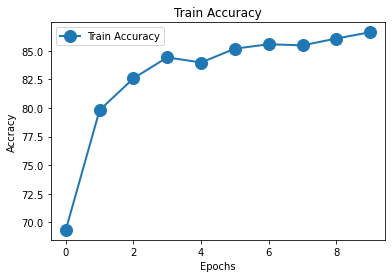

In [25]:
fig, ax = plt.subplots()
ax.plot(train_acc, marker='o', linestyle='-', linewidth=2, markersize=12, label='Train Accuracy')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accracy')
ax.set_title('Train Accuracy')
plt.show()

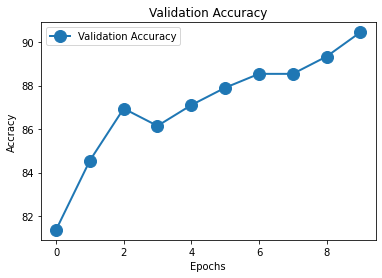

In [26]:
fig, ax = plt.subplots()
ax.plot(vali_acc, marker='o', linestyle='-', linewidth=2, markersize=12, label='Validation Accuracy')
plt.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Accracy')
ax.set_title('Validation Accuracy')
plt.show()

In [27]:
pred_vali = []
labels_vali = []
correct = 0
total = 0
with torch.no_grad():
  for i, data in enumerate(valiloader, 0):
    # get the inputs
    inputs, labels = data
    one_hot = torch.zeros(labels.size(0), 3)
    for batch_item in range(labels.size(0)):
        if labels[batch_item].cpu().numpy() == 0:
            one_hot[batch_item] = torch.tensor([1, 1, 0])
        if labels[batch_item].cpu().numpy() == 1:
            one_hot[batch_item] = torch.tensor([0, 1, 0])
        if labels[batch_item].cpu().numpy() == 2:
            one_hot[batch_item] = torch.tensor([0, 0, 1])

    inputs, labels, one_hot = Variable(inputs.to(device)), Variable(labels.to(device)), Variable(one_hot.to(device))

    output = resnet18(inputs)
    one_hot = one_hot.float()
    output = torch.sigmoid(output)
    pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)

    pred_vali += list(pred.cpu().numpy())
    labels_vali += list(one_hot.cpu().numpy())
    total += labels.size(0)
    for batch_item in range(labels.size(0)):
        if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
            correct += 1

conf_matrix = multilabel_confusion_matrix(pred_vali, labels_vali)
print(conf_matrix)
print('\n')
print(f'Validation Accuracy {(100 * correct / total)}')

[[[598  19]
  [  2   9]]

 [[167  17]
  [ 33 411]]

 [[411  33]
  [ 17 167]]]


Validation Accuracy 88.85350318471338


In [28]:
pred_train = []
labels_train = []
correct = 0
total = 0
with torch.no_grad():
  for i, data in enumerate(trainloader, 0):
    # get the inputs
    inputs, labels = data
    one_hot = torch.zeros(labels.size(0), 3)
    for batch_item in range(labels.size(0)):
        if labels[batch_item].cpu().numpy() == 0:
            one_hot[batch_item] = torch.tensor([1, 1, 0])
        if labels[batch_item].cpu().numpy() == 1:
            one_hot[batch_item] = torch.tensor([0, 1, 0])
        if labels[batch_item].cpu().numpy() == 2:
            one_hot[batch_item] = torch.tensor([0, 0, 1])

    inputs, labels, one_hot = Variable(inputs.to(device)), Variable(labels.to(device)), Variable(one_hot.to(device))

    output = resnet18(inputs)
    one_hot = one_hot.float()
    output = torch.sigmoid(output)
    pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)

    pred_train += list(pred.cpu().numpy())
    labels_train += list(one_hot.cpu().numpy())
    total += labels.size(0)
    for batch_item in range(labels.size(0)):
        if np.array_equal(pred[batch_item].cpu().numpy(), one_hot[batch_item].cpu().numpy()):
            correct += 1

conf_matrix = multilabel_confusion_matrix(pred_train, labels_train)
print(conf_matrix)
print('\n')
print(f'Training Accuracy {(100 * correct / total)}')

[[[5989  152]
  [  11   48]]

 [[1554  212]
  [ 446 3988]]

 [[3990  446]
  [ 210 1554]]]


Training Accuracy 87.03225806451613


In [0]:
# Test CSV File
f = open('resent18_focal_loss.csv', 'w')
writer = csv.writer(f)
for inputs, label, path in testloader:
    # use the above variables freely
    inputs = Variable(inputs.to(device))
    output = vgg16(inputs)
    output = torch.sigmoid(output)
    pred = torch.as_tensor((output - 0.5) > 0, dtype=torch.int32)
    input_row = []
    input_row.append(str(list(path)[0]).split('/')[-1])
    input_row.append(int(pred[0][0].cpu().numpy()))
    input_row.append(int(pred[0][1].cpu().numpy()))
    input_row.append(int(pred[0][2].cpu().numpy()))
    writer.writerow(input_row)
f.close()